In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, IntSlider, FloatSlider, interactive_output
from IPython.display import display

# Global variables for caching simulation results.
cached_params = None
cached_history = None

def simulate_gray_scott(F, k, Du, Dv, steps, n, sample_interval, num_perturb):
    """
    Run the Gray-Scott simulation with multiple random perturbations.
    
    Parameters:
      F, k: Feed and kill rates.
      Du, Dv: Diffusion coefficients.
      steps: Total number of time steps.
      n: Grid size (n x n).
      sample_interval: Record a frame every this many steps.
      num_perturb: Number of random perturbations.
      
    Returns:
      history: A list of snapshots (arrays) of U over time.
    """
    dt = 1.0
    dx = 1.0
    U = np.ones((n, n))
    V = np.zeros((n, n))
    
    # If perturbations are requested, apply multiple random ones.
    if num_perturb > 0:
        # A small patch size relative to grid size.
        r = n // 20  
        for _ in range(num_perturb):
            # Choose a random center, ensuring the patch is contained.
            i_center = np.random.randint(r, n - r)
            j_center = np.random.randint(r, n - r)
            U[i_center - r:i_center + r, j_center - r:j_center + r] = 0.50
            V[i_center - r:i_center + r, j_center - r:j_center + r] = 0.25
    else:
        # Fallback: a default center perturbation.
        r = n // 10  
        U[n//2 - r:n//2 + r, n//2 - r:n//2 + r] = 0.50
        V[n//2 - r:n//2 + r, n//2 - r:n//2 + r] = 0.25
    
    history = []  # To store snapshots of U
    for i in range(steps):
        # Compute the Laplacian (with periodic boundaries)
        Ulap = (
            np.roll(U, 1, axis=0) + np.roll(U, -1, axis=0) +
            np.roll(U, 1, axis=1) + np.roll(U, -1, axis=1) - 4 * U
        ) / dx**2
        
        Vlap = (
            np.roll(V, 1, axis=0) + np.roll(V, -1, axis=0) +
            np.roll(V, 1, axis=1) + np.roll(V, -1, axis=1) - 4 * V
        ) / dx**2
        
        # Reaction terms for the Gray-Scott model.
        uvv = U * V * V
        U += dt * (Du * Ulap - uvv + F * (1 - U))
        V += dt * (Dv * Vlap + uvv - (F + k) * V)
        
        # Save the state at fixed intervals.
        if i % sample_interval == 0:
            history.append(U.copy())
    
    return history

def update_plot(frame, F, k, Du, Dv, steps, n, sample_interval, num_perturb):
    """
    Update and display the simulation snapshot based on slider values.
    
    Parameters:
      frame: Index of the frame to display.
      F, k, Du, Dv, steps, n, sample_interval: Simulation parameters.
      num_perturb: Number of random perturbations.
    """
    global cached_params, cached_history
    
    # Build a tuple of current simulation parameters (except the time/frame).
    current_params = (F, k, Du, Dv, steps, n, sample_interval, num_perturb)
    
    # Re-run simulation only if the parameters have changed.
    if current_params != cached_params:
        cached_history = simulate_gray_scott(F, k, Du, Dv, steps, n, sample_interval, num_perturb)
        cached_params = current_params
        # Adjust the time slider's max based on saved frames.
        time_slider.max = len(cached_history) - 1

    # Plot the requested frame.
    plt.figure(figsize=(4,4))
    plt.imshow(cached_history[frame], cmap='inferno', origin='lower')
    plt.title(f"Frame: {frame} (Step: {frame * sample_interval})")
    plt.axis('off')
    plt.show()

# Create sliders for time and simulation parameters.
time_slider = IntSlider(min=0, max=100, step=1, value=0, description='Time')
F_slider = FloatSlider(min=0.0, max=0.1, step=0.005, value=0.03, description='F')
k_slider = FloatSlider(min=0.0, max=0.1, step=0.005, value=0.07, description='k')
Du_slider = FloatSlider(min=0.01, max=0.3, step=0.01, value=0.20, description='Du')
Dv_slider = FloatSlider(min=0.01, max=0.3, step=0.01, value=0.08, description='Dv')
steps_slider = IntSlider(min=100, max=10000, step=100, value=1000, description='Steps')
n_slider = IntSlider(min=50, max=200, step=10, value=100, description='Grid size')
sample_slider = IntSlider(min=1, max=20, step=1, value=10, description='Frame interval')
perturb_slider = IntSlider(min=0, max=20, step=1, value=9, description='Perturbations')

# Arrange the widgets.
controls = VBox([
    time_slider,
    F_slider, k_slider,
    Du_slider, Dv_slider,
    steps_slider, n_slider, sample_slider,
    perturb_slider
])

# Create the interactive output.
out = interactive_output(update_plot, {
    'frame': time_slider,
    'F': F_slider,
    'k': k_slider,
    'Du': Du_slider,
    'Dv': Dv_slider,
    'steps': steps_slider,
    'n': n_slider,
    'sample_interval': sample_slider,
    'num_perturb': perturb_slider
})

display(VBox([controls, out]))


# Analysis of Gray-Scott simulation
## Parameter robustness test

### Quantify images
- Spatial Variance: Variance of the U or V field 
- Edge Count: Use edge detection (e.g., Sobel filter) to count structure
- FFT Spectrum Entropy: 
- Cluster Count: Use thresholding + labeling (e.g., scipy.ndimage.label) to count blobs

In [21]:
from scipy.ndimage import sobel
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy, label
from scipy.signal import correlate2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import os

import seaborn as sns

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

In [3]:
# Edge Count
def edge_density(U):
    '''
    Input:
    - Single frame pattern, np array
    Output:
    - Sobel index: the mean of overall edge strength
        - Estimate the gradient (i.e., how fast pixel intensities change) in an image. Areas with strong intensity changes are likely to be edges
        - Sobel computes partial derivatives in the x and y directions using convolution with small 3x3 filters (kernels)
    '''
    dx = sobel(U, axis=0) # horizontal (x) gradient
    dy = sobel(U, axis=1) # horizontal (y) gradient
    #edge_mag = np.hypot(dx, dy) # Overall edge strength
    return np.mean(dx), np.mean(dy)
    

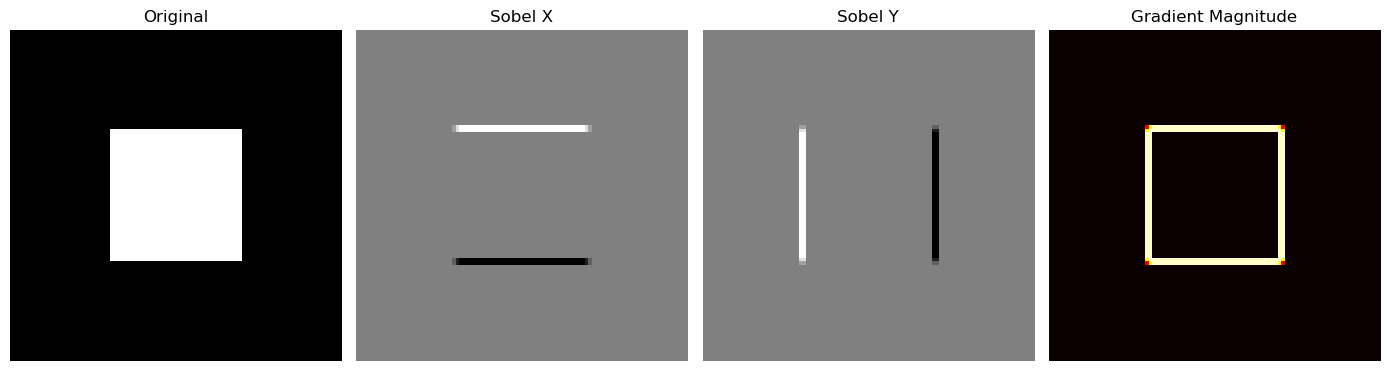

In [4]:
# Example of sobel
# Create an image with a square in the center
image = np.zeros((100, 100))
image[30:70, 30:70] = 1.0

# Apply Sobel filters
dx = sobel(image, axis=0)  # Horizontal (x) gradient
dy = sobel(image, axis=1)  # Vertical (y) gradient
grad_mag = np.hypot(dx, dy)  # Overall edge strength; Euclidean

# Plot results
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(image, cmap='gray'); axs[0].set_title("Original")
axs[1].imshow(dx, cmap='gray'); axs[1].set_title("Sobel X")
axs[2].imshow(dy, cmap='gray'); axs[2].set_title("Sobel Y")
axs[3].imshow(grad_mag, cmap='hot'); axs[3].set_title("Gradient Magnitude")

for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def extract_features(img):

    x_edges, y_edges = edge_density(img)

    entropy = shannon_entropy(img)
    std = np.std(img)
    mean = np.mean(img)
    
    # connected components
    labeled = label(img > 0.5)
    n_components = labeled.max()

    # spectrum energy
    fft_img = np.abs(np.fft.fftshift(np.fft.fft2(img)))
    high_freq_energy = np.mean(fft_img[img.shape[0]//4:-img.shape[0]//4, img.shape[1]//4:-img.shape[1]//4])
    
    return [mean, std, entropy, x_edges, y_edges, n_components, high_freq_energy]

In [6]:
def sweep_parameter(param_name, param_range, fixed_params):
    """
    Sweep a parameter over a range and compute the features for each value.
    
    Parameters:
      param_name: Name of the parameter to sweep (e.g., 'F', 'k').
      param_range: Values to test for the parameter.
      fixed_params: Dictionary of other parameters to keep constant.
      
    Returns:
      metrics: dictionary of features for each parameter value.
    """
    metrics = {'mean': [], 'std': [], 'entropy': [],
              'x_edges': [], 'y_edges': [], 'n_components': [],
              'high_freq_energy': []}
    for value in param_range:
        params = fixed_params.copy()
        params[param_name] = value
        history = simulate_gray_scott(**params)
        # Compute the mean edge density across all frames
        feature = [extract_features(frame) for frame in history]
        metrics['mean'].append(np.mean([f[0] for f in feature]))
        metrics['std'].append(np.mean([f[1] for f in feature]))
        metrics['entropy'].append(np.mean([f[2] for f in feature]))
        metrics['x_edges'].append(np.mean([f[3] for f in feature]))
        metrics['y_edges'].append(np.mean([f[4] for f in feature]))
        metrics['n_components'].append(np.mean([f[5] for f in feature]))
        metrics['high_freq_energy'].append(np.mean([f[6] for f in feature]))

        df = pd.DataFrame(metrics)
    return df

# Example: Sensitivity to F
fixed_params = dict(F=0.03, k=0.04, Du=0.2, Dv=0.1,
                    steps=1000, n=100, sample_interval=10, num_perturb=9)

F_range = np.linspace(0.01, 0.08, 20)
k_range = np.linspace(0.01, 0.08, 20)
Du_range = np.linspace(0.01, 0.3, 20)
Dv_range = np.linspace(0.01, 0.3, 20)
perturb_range = np.arange(0, 20, 1)

k_metrics = sweep_parameter('k', k_range, fixed_params)
F_metrics = sweep_parameter('F', F_range, fixed_params)
Du_metrics = sweep_parameter('Du', Du_range, fixed_params)
Dv_metrics = sweep_parameter('Dv', Dv_range, fixed_params)
perturb_metrics = sweep_parameter('num_perturb', perturb_range, fixed_params)


/var/folders/rl/lw8rs5q93qv7zwkm123fnnrw0000gn/T/ipykernel_56043/3191726621.py:60: RuntimeWarning: overflow encountered in multiply
  uvv = U * V * V
/var/folders/rl/lw8rs5q93qv7zwkm123fnnrw0000gn/T/ipykernel_56043/3191726621.py:61: RuntimeWarning: invalid value encountered in add
  U += dt * (Du * Ulap - uvv + F * (1 - U))
/var/folders/rl/lw8rs5q93qv7zwkm123fnnrw0000gn/T/ipykernel_56043/3191726621.py:62: RuntimeWarning: invalid value encountered in add
  V += dt * (Dv * Vlap + uvv - (F + k) * V)
/var/folders/rl/lw8rs5q93qv7zwkm123fnnrw0000gn/T/ipykernel_56043/3191726621.py:50: RuntimeWarning: invalid value encountered in add
  np.roll(U, 1, axis=0) + np.roll(U, -1, axis=0) +
/var/folders/rl/lw8rs5q93qv7zwkm123fnnrw0000gn/T/ipykernel_56043/3191726621.py:55: RuntimeWarning: invalid value encountered in add
  np.roll(V, 1, axis=0) + np.roll(V, -1, axis=0) +
/opt/anaconda3/envs/turingpattern/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountere

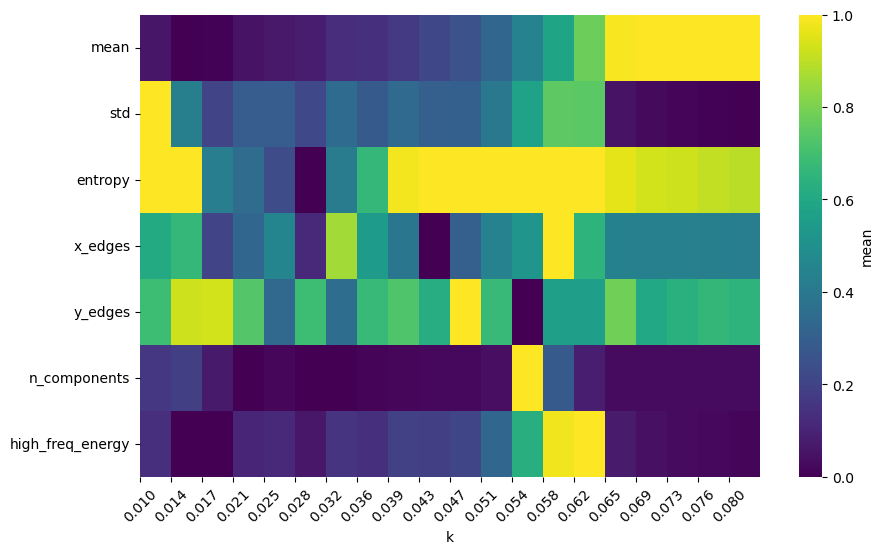

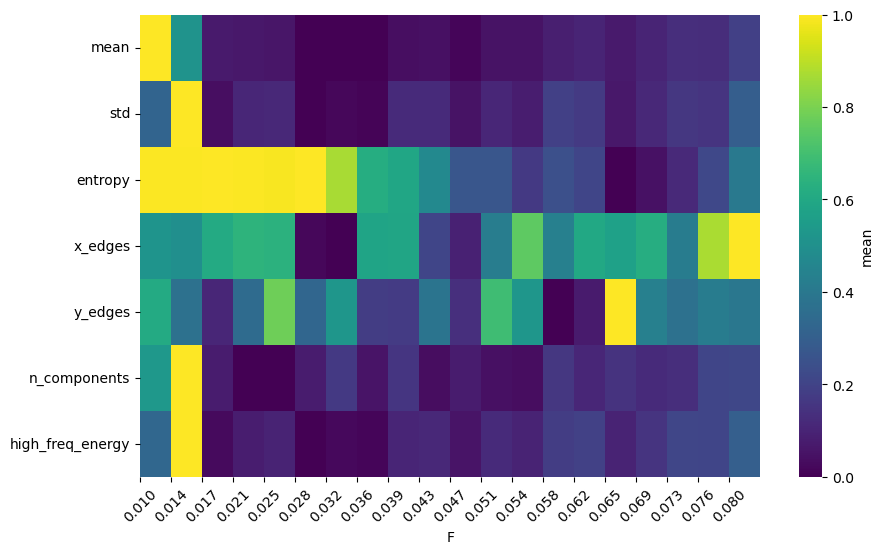

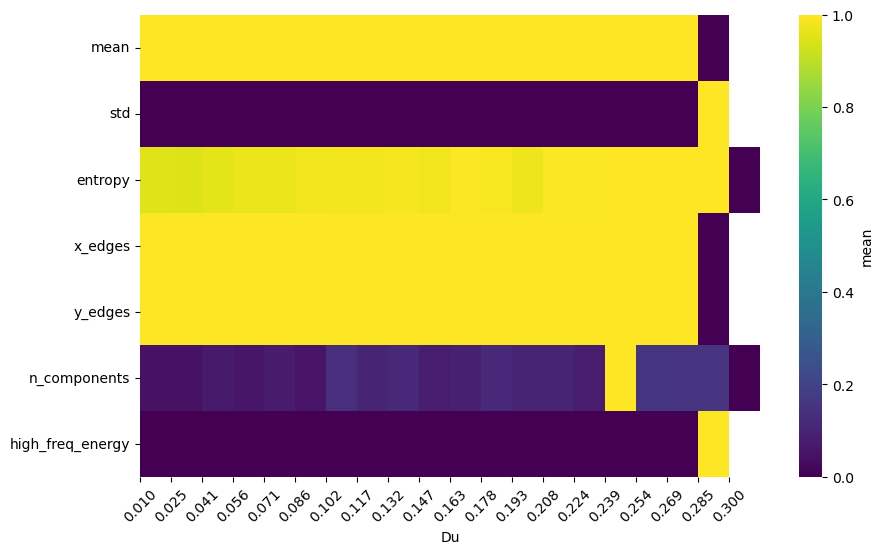

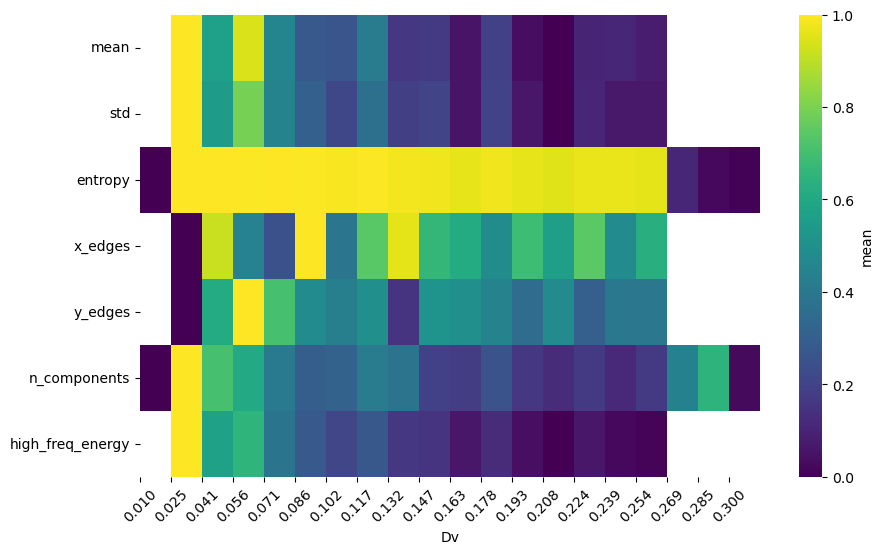

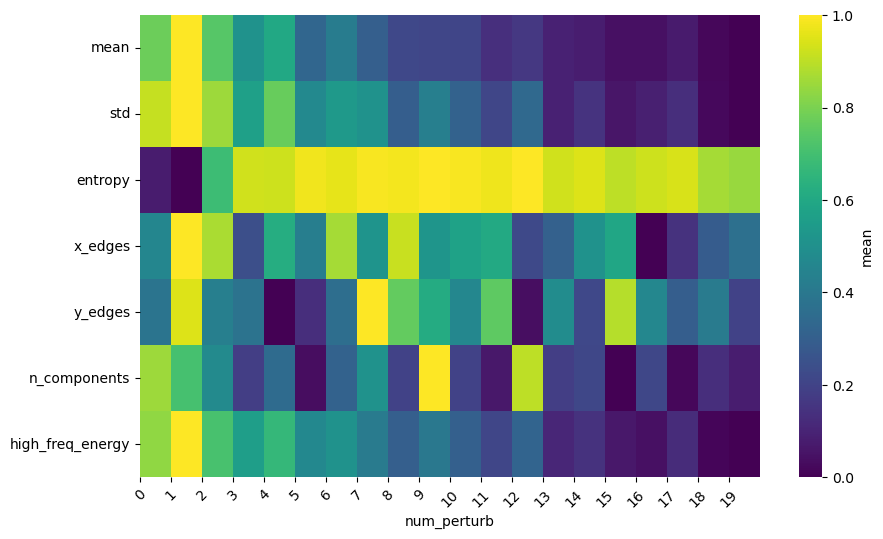

In [19]:
range_metrics = [k_range, F_range, Du_range, Dv_range, perturb_range]
params = ['k', 'F', 'Du', 'Dv', 'num_perturb']

for i, metrics in enumerate([k_metrics, F_metrics, Du_metrics, Dv_metrics, perturb_metrics]):
    para = params[i]
    ran = range_metrics[i]
    plt.figure(figsize=(10, 6))
    # normalize the metrics
    normalized_metrics = (metrics - metrics.min()) / (metrics.max() - metrics.min())
    sns.heatmap(normalized_metrics.T, cmap='viridis', cbar_kws={'label': metrics.columns[0]})
    if i !=4:
        plt.xticks(ticks=np.arange(len(ran)), labels=[f"{val:.3f}" for val in ran])
    else:
        plt.xticks(ticks=np.arange(len(ran)), labels=[f"{val}" for val in ran])
    plt.xticks(rotation=45)
    plt.xlabel(para)


In [22]:
# difference between patterns to quantify pattern change 
def pattern_diff(img1, img2):
    return 1 - ssim(img1, img2,data_range=1.0)

# quantify stablility time
def compute_stability_time(history, threshold=1e-4, window=5):
    diffs = [np.mean((history[t+1] - history[t])**2) for t in range(len(history) - 1)]
    for i in range(len(diffs) - window):
        if all(d < threshold for d in diffs[i:i+window]):
            return i
    return len(history) - 1

# set parameter
F_list = np.linspace(0.01, 0.07, 7)
k_list = np.linspace(0.045, 0.08, 7)

results = []
feature_names = ['mean', 'std', 'entropy', 'x_edge', 'y_edge', 'n_components', 'high_freq_energy']
all_features = []
all_labels = []
all_stable_times = []
pattern_change_map = {}


for i, F in enumerate(F_list):
    for j, k in enumerate(k_list):
        hist = simulate_gray_scott(F, k, Du=0.2, Dv=0.1, steps=2000, n=100, sample_interval=200, num_perturb=5)
        last_img = hist[-1]
        feat = extract_features(last_img)
        stable_time = compute_stability_time(hist)
        all_features.append(feat)
        all_labels.append((F, k))
        all_stable_times.append(stable_time)
        if j > 0:
            prev_img = simulate_gray_scott(F, k_list[j-1], Du=0.2, Dv=0.1, steps=2000, n=100, sample_interval=200, num_perturb=5)[-1]
            delta = pattern_diff(last_img, prev_img)
            pattern_change_map[(F, k)] = delta

# sensitivity to parameter
features_array = np.array(all_features).reshape(len(F_list), len(k_list), -1)

sensitivity_F = np.gradient(features_array, axis=0)
sensitivity_k = np.gradient(features_array, axis=1)

# PCA and clustering 
features_flat = features_array.reshape(-1, features_array.shape[-1])
# zscore
scaler = StandardScaler()
features_flat = scaler.fit_transform(features_flat)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_flat)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_pca)
cluster_labels = kmeans.labels_

# package
df = pd.DataFrame(all_features, columns=feature_names)
df['F'] = [f for f, _ in all_labels]
df['k'] = [k for _, k in all_labels]
df['stable_time'] = all_stable_times
df['cluster'] = cluster_labels


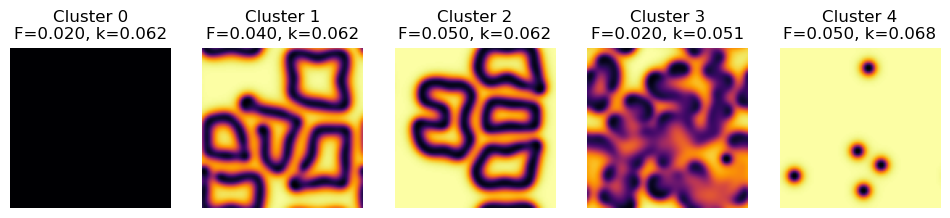

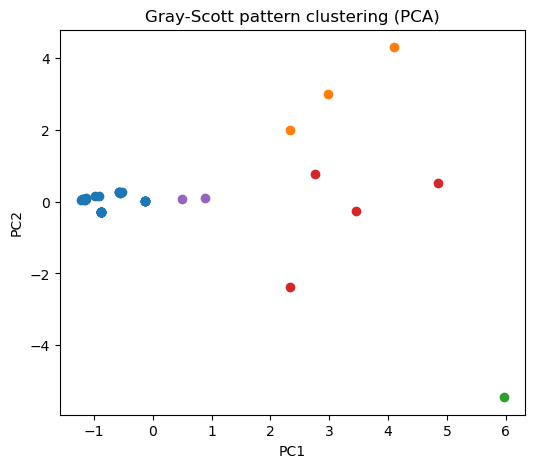

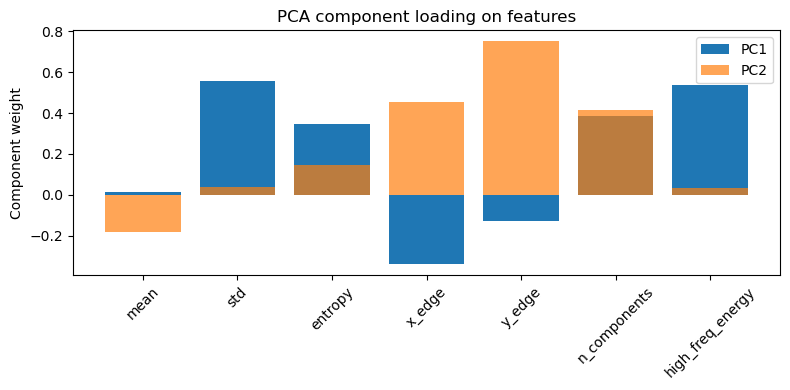

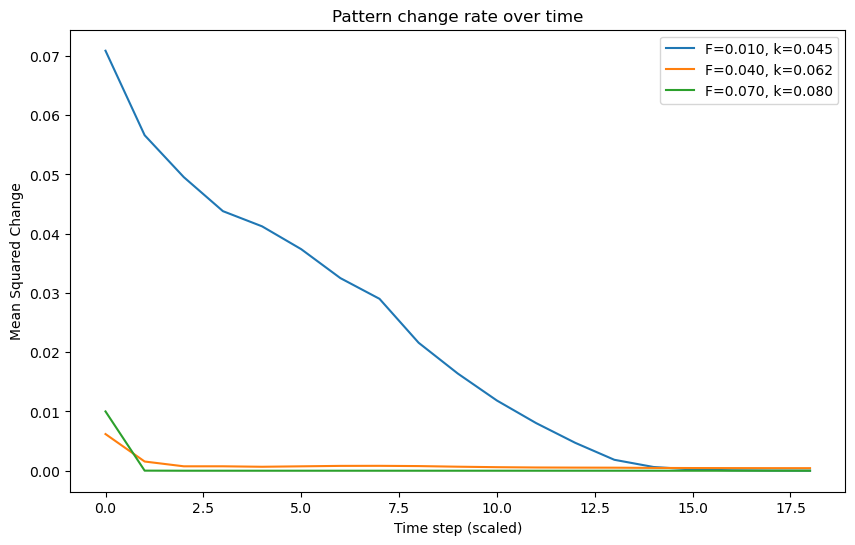

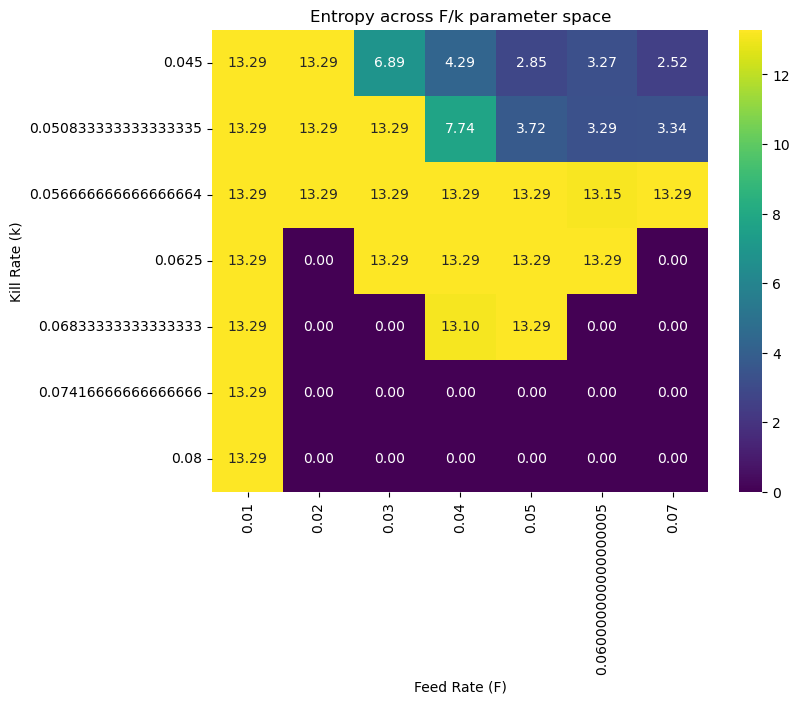

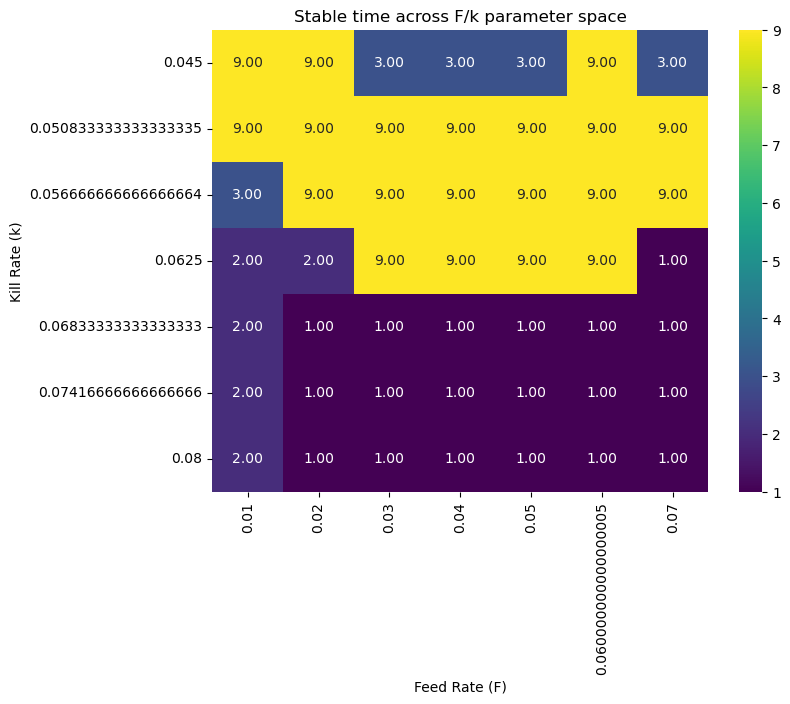

In [23]:
# representative sample of cluster
# the sample closest to the center of the cluster
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_pca)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(closest):
    F, k = all_labels[idx]
    hist = simulate_gray_scott(F, k, Du=0.2, Dv=0.1, steps=2000, n=100, sample_interval=200, num_perturb=5)
    img = hist[-1]
    plt.subplot(1, len(closest), i + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Cluster {i}\nF={F:.3f}, k={k:.3f}')
    plt.axis('off')
plt.show()

# dimensionality reduction and cluster plot
plt.figure(figsize=(6, 5))
for i in range(len(X_pca)):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], c=f"C{cluster_labels[i]}")
plt.title("Gray-Scott pattern clustering (PCA)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# major contributor of PCA
components = pca.components_
plt.figure(figsize=(8, 4))
plt.bar(feature_names, components[0], label='PC1')
plt.bar(feature_names, components[1], label='PC2', alpha=0.7)
plt.ylabel("Component weight")
plt.title("PCA component loading on features")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# changing rate of the image 
plt.figure(figsize=(10, 6))
selected_indices = [0, len(df)//2, len(df)-1]
for idx in selected_indices:
    F, k = df.iloc[idx]['F'], df.iloc[idx]['k']
    hist = simulate_gray_scott(F, k, Du=0.2, Dv=0.1, steps=1000, n=100, sample_interval=50, num_perturb=5)
    diffs = [np.mean((hist[t+1] - hist[t])**2) for t in range(len(hist) - 1)]
    plt.plot(diffs, label=f"F={F:.3f}, k={k:.3f}")
plt.xlabel("Time step (scaled)")
plt.ylabel("Mean Squared Change")
plt.title("Pattern change rate over time")
plt.legend()
plt.show()

# Distribution of entropy and stable time in parameter space
def plot_heatmap(df, value_col, title):
    heatmap_data = df.pivot(index='k', columns='F', values=value_col)
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f")
    plt.title(title)
    plt.xlabel('Feed Rate (F)')
    plt.ylabel('Kill Rate (k)')
    plt.show()

plot_heatmap(df, 'entropy', 'Entropy across F/k parameter space')
plot_heatmap(df, 'stable_time', 'Stable time across F/k parameter space')

